## Programming Exercise 4: Neural Networks Learning

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import time
import itertools
from scipy.special import expit

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

### 1 Neural Networks

#### 1.1 Visualizing the data

데이터 확인하고 시각화해보자. 다루는 데이터가 어떤 종류인지, 몇차원으로 이루어져 있는지 생각하자.

**Q. 데이터 X, y에 대한 정보와 이것으로 무엇을 할 건지 아래에 서술해보자.**

In [17]:
# 데이터를 불러오자. 
datafile = './data/ex4data1.mat'
# scipy에 loadmat이라는 mat파일을 불러오는 함수를 사용한다. 
mat = scipy.io.loadmat(datafile)

# X, y를 지정해준다. 
X, y = mat['X'], mat['y']

## X와 y가 어떤 값들로 이루어져 있는지 확인해보자. 
#1. X, y의 shape 확인한다. 
#2. X는 이미지, y는 label 정보이다. y가 몇 가지 class의 label로 이루어져 있는지 확인해보자. (np.unique를 쓰자.)

### 코드 시작 ###
print ("X has shape :",X.shape)
print ("y has shape :",y.shape)
np.unique(y)
### 코드 끝 ###

('X has shape :', (5000, 400))
('y has shape :', (5000, 1))


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [18]:
# X에 2번째 열에 1을 insert 해주자. 
X = np.insert(X, 0, 1, axis=1)
print (X.shape)

(5000, 401)


#### 1.2 Visualizing the data

X를 이미지로, y를 label로 사용할 것이다. 아래는 각 `class(label)` 에 대한 X값을 이미지로 나타낸 것이다.

앞선 **Logistic, Linear** 에서는 2차원 평면에 나타냈고 이번에는 이미지라서 각각 이미지로 나타냈다.

아래 코드를 보면서 matplotlib로 image 나타내는 것을 익혀보자. 

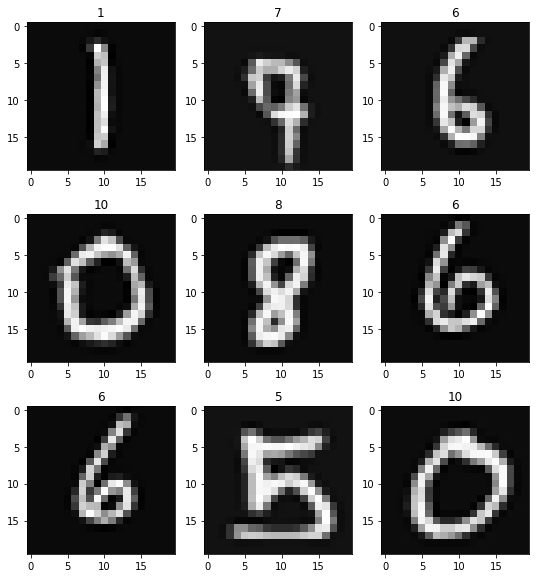

In [20]:
# X, y가 뭐로 이루어져 있는지 확인해보자. 
# random seed는 계속 뽑을 때마다 무작위로 되는 걸 방지하기 위해서 사용한다. 숫자 별로 무작위 값이 지정되어 있다. 
np.random.seed(42)
# 랜덤으로 그래프 그릴 데이터의 index를 5000개 중에 9개를 뽑는다. 
random_indices = np.random.choice(5000, 9)
# 뽑은 index를 사용해서 9개의 값만 따로 저장해준다.
X_sample, y_sample = X[random_indices], y[random_indices]
# 3행, 3열로 그래프를 그릴 예정이다. 
rows, cols = 3, 3
# figure를 만들어준다. 
plt.figure(figsize=(9, 10))
for row in range(rows):
    for col in range(cols):
        order = row * cols + col 
        # 그래프의 행, 열에 해당하는 정보가 들어가면서 생성된다.  
        plt.subplot(rows, cols, order + 1)
        # array를 받아서 이미지로 나타내주는 그래프이다. colormap은 gray로 해주어야 흑백이 나온다. 
        plt.imshow(X_sample[order][1:].reshape([20, 20]).transpose(), cmap='gray')
        # 그래프에 맞는 y값을 매칭시켜준다. 
        plt.title(y_sample[order][0])        

#### 1.2 Model representation

In [34]:
# 이미 학습되어 있는 weight 값들을 불러올 거다. 
datafile = 'data/ex4weights.mat'
# 위와 마찬가지로 scipy.io.loadmat으로 불러온다. 
mat = scipy.io.loadmat(datafile)
# 각 layer 별 theta를 theta1, theta2 로 지정해준다. 
theta1, theta2 = mat['Theta1'], mat['Theta2']

# theta의 shape을 확인해보고 shape의 의미를 써보자. 
### 코드 시작 ###
print ("Theta1 has shape :", theta1.shape)
print ("Theta2 has shape :", theta2.shape)
### 코드 끝 ###

('Theta1 has shape :', (25, 401))
('Theta2 has shape :', (10, 26))


In [35]:
# Bias를 빼고 우리가 아는 정보들을 모아서 변수에 선언하자. 
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0]
thetas = [theta1, theta2]

#### 1.3 Feedforward and cost function

ex.3에서 구현한 `forwardpropagate` 함수를 사용하자. 

In [36]:
# logistic regression에서 쓴 sigmoid 함수가 또 필요하다. 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
    
# forwardpropagate을 하자. 
# 앞 강의에서 내용과 조금 다른 부분이 있는데 앞에서는 마지막 값 a(h)만 내놓은 반면에 여기에선 Backpropagation을 위해서
# 각 layer 별 output을 전부다 모아야 한다. 
def forwardpropagate(X,thetas):
    """
    X : input 값. (array)
    Thetas : layer 별로 필요한 theta 값들. (list)
    
    X를 받아서 layer 별로 진행한 뒤에 output을 내놓는 것이 목적이다. 
    """
    ##############################################################################
    # 1. input으로 X를 받는다. 
    #  -> layer를 지날 때마다 값이 계속 바뀌므로 features에 넣고 loop를 돌리는게 낫다. 
    # 2. layer가 지날 때마다 weight(theta)와 연산이 되고 bias가 더해져서 전달된다. 
    #  -> bias는 강의 자료에 나오듯 1을 더해주면 된다. (np.insert) 
    # 3. 마지막 layer에서는 bias가 더해지지 않고 sigmoid 함수가 쓰여서 값을 0 - 1 사이로 만들어준다. 
    ##############################################################################
    features = X
    z_and_a_per_layer = []
    ### 코드 시작 ###
    ######### 코드의 정확한 설명 필요 #########
    for i in range(len(thetas)):
        theta = thetas[i]
        z = np.dot(features, theta.T)
        a = sigmoid(z)
        z_and_a_per_layer.append((z, a))
        if i == len(thetas) - 1:
            return z_and_a_per_layer
        a = np.insert(a, 0, 1, axis=1)
        features = a

## Cost function 구현

아래 코드에서 Cost Function을 구현할 것이다. 강의 자료에 나온 수식을 그대로 구현하면 된다.

$ J(\theta) = - \frac {1} {m} \big [ \sum_{i=1}^m \sum_{k=1}^K y_k^{(i)}log\ h_{\theta}(x^{(i)})_k + (1 - y_k^{(i)}) log(1 - h_{\theta}(x^{(i)})_k \big ] + \frac {\lambda} {2m} \sum_{j=1}^n {\theta}_j^2 $

앞 부분은 항을 하나하나 다 풀어서 썼고 뒷 부분은 안 풀어서 썼는데, 뒷 부분 계산은 그냥 matrix로 해도 딱히 이해에 어려움이 없기 때문이다. <br> 
(*각 theta를 죄다 제곱을 취한 뒤에 모든 항을 더해주면 된다.*)

이제 위에서 앞 식을 풀어야 되는데, 걸리는 부분이 $y$에 해당하는 부분이다. 우리가 데이터로 받은 y의 shape은 (5000, 1)로 식에서 
풀려고 하는 (5000, 10) 과는 다른 형태이다. 그래서 y의 형태를 바꿔주는 것이 필요하다. 

y가 나타내는 정보는 class, 즉 숫자의 값을 나타낸다. <br>
형태를 바꿔서 현재 ***class를 나타내는 scalar 값을 0과 1로 이루어진 vector로 바꿔줄 수 있는데 이를 one-hot encoding 이라고 한다.*** 앞 부분 식 계산을 위해서 $y$에 one-hot encoding 을 사용할 것이다. 

아래에 구현할 때 아래 페이지를 참조해서 해보자. <br>
https://stackoverflow.com/questions/29831489/numpy-1-hot-array

one-hot encoding 개념 이해가 잘 안 될 경우 아래 페이지를 보자. <br>
https://minjejeon.github.io/learningstock/2017/06/05/easy-one-hot-encoding.html

In [37]:
# y를 one-hot 형태로 만들어주기 
# 1. 먼저 (5000, 10) shape의 0으로 이루어진 matrix를 만들어준다. np.zeros 사용
y_onehot = np.zeros([y.shape[0], output_layer_size])
# 2. y의 값이 해당하는 index 위치만 1로 변경해준다. np.arange, reshape 사용. 위에 첨부한 웹페이지 참조하자. 
y_onehot[np.arange(5000), y.reshape(1, -1) - 1] = 1 

***cost function을 2가지 형태로 구현 할 예정이다. ***
1. 완전 low level로, theta는 냅두고 matrix 각 항 별로 모든 값을 구해서 다 더하는 방식을 취한다.
2. vectorize 방식을 취한다.

--> 두 가지 방식으로 구현을 한 뒤에 속도 비교도 해보자. 

In [38]:
# low level (for loop)
def costfunction_vector(thetas, X, y_onehot, lambda_param=0):   
    m = X.shape[0]
    h_x = forwardpropagate(X, thetas)[-1][-1]
    cost_front = 0
    cost_back = 0
    cost_front = -(1.0/m) * np.sum(y_onehot * np.log(h_x) + (1 - y_onehot) * np.log(1 - h_x)) 
    for theta in thetas:
        cost_theta = 0.5 * lambda_param * np.sum(np.square(theta)) / m 
        cost_back += cost_theta
    cost_total = cost_front + cost_back
    return cost_total 

In [39]:
# vector
def costfunction_low(thetas, X, y_onehot, lambda_param=0):   
    m = X.shape[0]
    h_x = forwardpropagate(X, thetas)[-1][-1]
    cost_front = 0
    cost_back = 0
    for i in range(n_training_samples):
        for k in range(output_layer_size):
            cost_ik = - (1.0/m) * (y_onehot[i, k] * np.log(h_x[i, k]) + (1 - y_onehot[i, k]) * np.log(1 - h_x[i, k])) 
            cost_front += cost_ik
    for theta in thetas:
        cost_theta = 0.5 * lambda_param * np.sum(np.square(theta)) / m 
        cost_back += cost_theta
    cost_total = cost_front + cost_back
    return cost_total 

*** 위에서 구현한 cost function을 각각 실행시켜서 vectorize했을 때 시간이 얼마나 단축되는지 확인하자. *** 

In [40]:
start = time.time()
print(costfunction_low(thetas, X, y_onehot, 0))
end = time.time()
print("Running time for cost with for loop : {:.2f}s".format(end - start))

0.287629165161
Running time for cost with for loop : 0.13s


In [41]:
start = time.time()
print(costfunction_vector(thetas, X, y_onehot, 0))
end = time.time()
print("Running time for cost with vector : {:.2f}s".format(end - start))

0.287629165161
Running time for cost with vector : 0.03s


#### 1.4 Regularized cost function

Regularizer에 사용되는 lambda 값을 조정해서 cost function이 어떻게 되는지 확인해보자. 

**Q. Cost function은 어떻게 되나? 여기서 Regularizer의 역할은 뭘까?**

In [42]:
# lambda 값을 1로 놓고 cost function을 구해보자. 
print(costfunction_vector(thetas, X, y_onehot, 1))

0.384487796243


## Backpropagation

**목적 : chain rule을 통해서 각 layer내 unit별로 모든 theta값의 gradient를 구해야 한다. **

chain rule만 잘 사용하면 된다. 각각의 unit들의 연결은 식으로 나타나지고 하나의 식은 곧 바로 gradient를 구할 수 있다.

문제가 되는 부분은 여러 개의 식을 지났을 때인데, 하나의 식에 대한 gradient를 알면 chain rule을 통해서 구할 수 있다. 

이 부분에 대해서만 명확하게 이해하면 나머지는 별거 없는 알고리즘이다. 

내용에 대해서 아래 사이트를 보는 것을 추천한다. 강의 노트 내용은 notation도 너무 많고 수학적이라 이해가 잘 안된다. 

http://aikorea.org/cs231n/optimization-2/

#### 2.1 Sigmoid gradient

sigmoid의 경우는 exp 항이 들어가서 gradient를 구하는데 어려움이 있다. 굳이 전개 과정을 알 필요는 없고 
***어떤 식이 sigmoid의 gradient를 나타내는지만 알면 된다.***

아래 z에 대한 sigmoid 함수의 gradient 식을 참고하자. <br>
$\frac \partial {\partial z} \sigma(z) = \sigma(z) (1- \sigma(z))$

In [43]:
# sigmoid의 gradient를 구하자. 
def sigmoidGradient(z):
    a = sigmoid(z)
    return a * (1 - a)

#### 2.2 Random initialization

theta를 기존에는 0의 값들로 이루어진 matrix를 사용했는데 neural network에서 그렇게 사용할 경우에 초기에 학습이 잘 되지 않는다. 
(***왜 그런지 생각해보자.***) <br> 그래서 0에 가까운 작은 값들로 초기화를 시켜준다. 

In [44]:
def randomInitTheta():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

#### 2.3 Backpropagation

Neural Network에서 배우는 개념 중에 가장 중요하다. 명확하게 이해하도록 하자. <br>
표기법과 설명은 아래 그림을 참고해서 하도록 하겠다. 그리고 직관적인 이해를 위해 표기들은 전부다 대문자 Matrix로 나타내겠다. 

![NN](../../../../pictures/neural_network.png)

- 목표 : $J(\Theta)$에 대한 $\Theta^{(1)}, \Theta^{(2)}$ ***각각의 gradient를 구하기.*** ($\frac {\partial J(\Theta)} {\partial \Theta^{(1)}}, \frac {\partial J(\Theta)} {\partial \Theta^{(2)}}$)
- Forward 식 : 식이 진행되는 순서대로 쭉 나열해보자. <br>
    1) $ Z^2 = \Theta^{(1)} \cdot X$ <br>
    2) $ A^2 = g(Z^2)$ <br>
    3) $ Z^3 = \Theta^{(2)} \cdot A^2$ <br>
    4) $ H_{\Theta}(X) = g(Z^3)$ <br>
    5) $ J(\Theta) = -\frac 1 m \big [\sum Y{log}H_{\Theta}(X) + (1 - Y){log}(1-H_{\Theta}(X)) \big] + \frac \lambda {2m} \sum \Theta^2$
- Backward 식 : 거꾸로 바로 이전 식에 대한 항들의 gradient를 구해보자. <br>
    1) $\frac {\partial Z^2} {\partial \Theta^{(1)}} = \frac \partial {\partial \Theta^{(1)}} (\Theta^{(1)} \cdot X$) <br>
    2) $\frac {\partial A^2} {\partial Z^2} = \frac \partial {\partial Z^2} (g(Z^2))$ <br>
    3) $\frac {\partial Z^3} {\partial A^2} = \frac \partial {\partial A^2} (\Theta^{(2)} \cdot A^2)$ <br>
    4) $\frac {\partial Z^3} {\partial \Theta^{(2)}} = \frac \partial {\partial \Theta^{(2)}} (\Theta^{(2)} \cdot A^2)$ <br>
    5) $\frac {\partial H_{\Theta}(X)} {\partial Z^3} = \frac \partial {\partial Z^3} (g(Z^3))$ <br>
    6) $\frac {\partial J(\Theta)} {\partial H_{\Theta}(X)} = \frac \partial {\partial H_{Theta}(X)} (J(\Theta))$ <br>
위 식들을 이용해서 구해야 하는 목표 식 2개를 풀어서 나타내보도록 하자. <br>
*** 아래와 같이 식을 풀어서 나타낼 수 있고 위에서 계산한 Backward 1~5를 활용하면 목표 1, 2를 구할 수 있다는 것을 알았다. 
1~5를 구하는 것에 어려움은 sigmoid에 대한 gradient 밖에 없고 이는 위(2.1)에서 해결했으므로 각각의 gradient를 구현하고 아래 식에 대입하면 되겠다. ***

### 목표 1 : $\frac {\partial J(\Theta)} {\partial \Theta^{(1)}} = \frac {\partial J(\Theta)} {\partial H_{\Theta}(X)} \frac {\partial H_{\Theta(X)}} {\partial \Theta^{(1)}} = \frac {\partial J(\Theta)} {\partial H_{\Theta}(X)} \frac {\partial H_{\Theta(X)}} {\partial Z^3} \frac {\partial Z^3} {\partial \Theta^{(1)}} = \frac {\partial J(\Theta)} {\partial H_{\Theta}(X)} \frac {\partial H_{\Theta(X)}} {\partial Z^3} \frac {\partial Z^3} {\partial A^2} \frac {\partial A^2} {\partial \Theta^{(1)}} = \frac {\partial J(\Theta)} {\partial H_{\Theta}(X)} \frac {\partial H_{\Theta(X)}} {\partial Z^3} \frac {\partial Z^3} {\partial A^2} \frac {\partial A^2} {\partial Z^2} \frac {\partial Z^2} {\partial \Theta^{(1)}}$

### 목표 2 : $\frac {\partial J(\Theta)} {\partial \Theta^{(2)}} = \frac {\partial J(\Theta)} {\partial H_{\Theta}(X)} \frac {\partial H_{\Theta(X)}} {\partial \Theta^{(2)}} = \frac {\partial J(\Theta)} {\partial H_{\Theta}(X)} \frac {\partial H_{\Theta(X)}} {\partial Z^3} \frac {\partial Z^3} {\partial \Theta^{(2)}}$



In [283]:
def backpropagate(thetas, X, y_onehot, lambda_param=0.):
    m = X.shape[0]
    theta1, theta2 = thetas
    z_and_a_per_layer = forwardpropagate(X, thetas)
    # forward에서 구한 Z, A값들 불러오기. 위에서 forward, backward 식 그대로 구현 예정 
    Z2 = z_and_a_per_layer[0][0]
    A2 = z_and_a_per_layer[0][1]
    Z3 = z_and_a_per_layer[1][0]
    H = z_and_a_per_layer[1][1]

    # 위 수식 그대로 구현하기
    dJ_dH = -(1.0/m) * (y_onehot - H) / (H * (1 - H))
    dH_dZ3 = H * (1 - H)
    dJ_dZ3 = dJ_dH * dH_dZ3
    dA2_dZ2 = sigmoidGradient(Z2)
    dJ_dZ2 = np.dot(dJ_dZ3, theta2[:, 1:]) * dA2_dZ2
    
    # bias의 영향력을 따져야 한다. 
    A2 = np.insert(A2, 0, 1, axis=1)
    dJ_dtheta1 = np.dot(dJ_dZ2.T, X)
    dJ_dtheta2 = dJ_dZ3.T.dot(A2) 
    
    # 이름을 간단하게 바꿔주자
    dtheta1 = dJ_dtheta1
    dtheta2 = dJ_dtheta2 

    # regularization 
    dtheta1[:, 1:] = dtheta1[:, 1:] + (float(lambda_param/m) * theta1[:, 1:])
    dtheta2[:, 1:] = dtheta2[:, 1:] + (float(lambda_param/m) * theta2[:, 1:])
    
    dthetas = [dtheta1, dtheta2]
    
    return dthetas

In [284]:
dtheta1, dtheta2 = backpropagate(thetas, X, y_onehot)

#### 2.4 Gradient checking

내가 Backpropagation으로 구한 Gradient가 맞게 구한건지 확인하는 작업이다. (**analytic gradient**) <br>
확인은 $f'(x) = \displaystyle\lim_{h \to 0} \frac {f(x+h) - f(x)} {h}$ 식을 사용한 **numerical gradient** 를 이용한다. 

- Analytic gradient : 수식적으로 gradient를 구하는 방법. (예시: $\frac \partial {\partial x} (4x) = 4$)
- Numerical gradient : 위 식 참조. 아주 가까운 두 점을 잡고 기울기를 구하면 gradient를 근사해서 구할 수 있다. 

In [287]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """ 
    a naive implementation of numerical gradient of f at x 
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """ 
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

**Q. 아래 코드는 Gradient를 확인하는 코드이다. 엄청 오래 걸릴거다 왜 그럴까? **

In [289]:
# theta1 gradient 확인
f1 = lambda th : costfunction_vector([th, theta2], X, y_onehot)
theta1_grad_num = eval_numerical_gradient(f1, theta1, verbose=False)
print("theta1 gradient 차이 : {}".format(rel_error(dtheta1, theta1_grad_num)))

# theta2 gradient 확인
f2 = lambda th : costfunction_vector([theta1, th], X, y_onehot)
theta2_grad_num = eval_numerical_gradient(f2, theta2, verbose=False)
print("theta2 gradient 차이 : {}".format(rel_error(dtheta2, theta2_grad_num)))

theta1 gradient 차이 : 0.000426020638045
theta2 gradient 차이 : 1.86969328277e-07


#### 2.5 Regularized Neural Networks

In [17]:
#My back propagation already has regularization in it.
#For now, I will assume the regularization part is correct
#(since in this case the regularization code is simple, I'm quite confident)

#### 2.5 Learning parameters using fmincg

In [18]:
#Here I will use scipy.optimize.fmin_cg

def trainNN(mylambda=0.):
    """
    Function that generates random initial theta matrices, optimizes them,
    and returns a list of two re-shaped theta matrices
    """

    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X),y,mylambda),maxiter=50,disp=True,full_output=True)
    return reshapeParams(result[0])

In [19]:
#Training the NN takes about ~70-80 seconds on my machine
learned_Thetas = trainNN()

         Current function value: 0.295915
         Iterations: 50
         Function evaluations: 108
         Gradient evaluations: 108


In [20]:
#If your implementation is correct, you should see a reported training accuracy of about 95.3%
#(this may vary by about 1% due to the random initialization).

In [21]:
def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = range(1,10) + [10]
    output = propagateForward(row,Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(myX,myThetas,myy):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in xrange(n_total):
        if int(predictNN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print "Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total))

In [22]:
computeAccuracy(X,learned_Thetas,y)

Training set accuracy: 96.2%


In [23]:
#Let's see if I set lambda to 10, if I get the same thing
learned_regularized_Thetas = trainNN(mylambda=10.)

         Current function value: 1.073837
         Iterations: 50
         Function evaluations: 143
         Gradient evaluations: 142


In [24]:
computeAccuracy(X,learned_regularized_Thetas,y)

Training set accuracy: 93.1%


### 3 Visualizing the hidden layer

In [25]:
def displayHiddenLayer(myTheta):
    """
    Function that takes slices of the first Theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into a 20x20 image, and shows it
    """
    #remove bias unit:
    myTheta = myTheta[:,1:]
    assert myTheta.shape == (25,400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        #add bias unit back in?
        iimg = getDatumImg(np.insert(row,0,1))
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

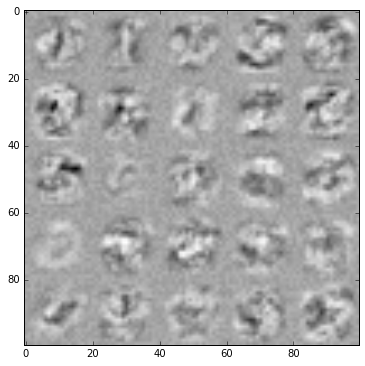

In [26]:
displayHiddenLayer(learned_Thetas[0])